In [1]:
import time
import os
import sys
import glob
import numpy as np
import pandas as pd
import cftime
import xarray as xr
import dask
from dask import delayed, compute

# check dask configuration

In [1]:
import dask
print(dask.__version__)


2022.11.0


In [2]:
from dask.distributed import Client

client = Client()  # This will connect to a local Dask scheduler
print(client)

<Client: 'tcp://127.0.0.1:33300' processes=9 threads=72, memory=1.47 TiB>


In [3]:
from dask import config

config.get('distributed')

{'version': 2,
 'scheduler': {'allowed-failures': 3,
  'bandwidth': 100000000,
  'blocked-handlers': [],
  'contact-address': None,
  'default-data-size': '1kiB',
  'events-cleanup-delay': '1h',
  'idle-timeout': None,
  'transition-log-length': 100000,
  'events-log-length': 100000,
  'work-stealing': True,
  'work-stealing-interval': '100ms',
  'worker-saturation': 1.1,
  'worker-ttl': '5 minutes',
  'pickle': True,
  'preload': [],
  'preload-argv': [],
  'unknown-task-duration': '500ms',
  'default-task-durations': {'rechunk-split': '1us', 'split-shuffle': '1us'},
  'validate': False,
  'dashboard': {'status': {'task-stream-length': 1000},
   'tasks': {'task-stream-length': 100000},
   'tls': {'ca-file': None, 'key': None, 'cert': None},
   'bokeh-application': {'allow_websocket_origin': ['*'],
    'keep_alive_milliseconds': 500,
    'check_unused_sessions_milliseconds': 500}},
  'locks': {'lease-validation-interval': '10s', 'lease-timeout': '30s'},
  'http': {'routes': ['distribut

In [4]:
from dask.distributed import Client

client = Client()  # Start or connect to a Dask cluster
print(client.dashboard_link)  # This will output a link to access the Dask dashboard


/home/innag3580/.conda/envs/movie/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33968 instead
  warnings.warn(


http://127.0.0.1:33968/status


**Dask Version:**

Version: 2022.11.0

**Dask Client:**

- Client Address: tcp://127.0.0.1:33300
- Number of Processes: 9
- Threads per Process: 72
- Total Memory: Approximately 1.47 TiB

**Scheduler Configuration:**

- Type: The setup uses a local Dask scheduler with multiple processes.
- Allowed Failures: The scheduler allows up to 3 failures for tasks before retrying.
- Work-Stealing: Enabled, meaning idle workers can take tasks from busy workers to optimize resource use.
- Dashboard Link: Available at http://127.0.0.1:33968/status with a linked web interface for monitoring.

**Worker Configuration:**

- Multiprocessing Method: Using spawn for creating worker processes.
- Maximum Connections: Workers can handle 50 outgoing and 10 incoming connections.
- Memory Settings: There are thresholds defined for spilling, pausing, and terminating based on memory usage.

**Resource Management:**

- Active Memory Manager: Enabled to manage memory usage actively and reduce resource contention.

**Networking:**

- Communication Protocols: TCP is being used for worker communication.

**Warnings:**

A warning indicates that port `8787` is already in use, which could mean that another Dask cluster instance is running. Therefore, the HTTP server is being hosted on a different port (`33968`).

**Dashboard:**

You can access the Dask dashboard to monitor the status, tasks, and performance of your Dask cluster. The dashboard provides visual insights into how tasks are being executed.

**Summary:**

Overall, your setup indicates a capable local Dask environment optimized for processing large datasets with multiple worker processes and threads. You can check the dashboard for real-time monitoring and diagnostics to ensure tasks are executed efficiently. If you encounter any issues or need modifications, you can adjust the configuration settings accordingly.

# test code

In [2]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def process_time_period(time_period, files, var, output_dir):
    try:
        #mean_ds = xr.open_mfdataset(files, preprocess=standardise_time, concat_dim='new_dim', combine='nested').mean(dim='new_dim')
        #output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
        #mean_ds.to_netcdf(output_file)
        
        print(f'mean for {time_period} saved')
    except Exception as e:
        print(f"Error processing: {e}")

In [3]:
var = 'TEMP'
base_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly'
output_dir = '/Data/skd/scratch/innag3580/comp/averages'

var_dir = os.path.join(base_dir, var)
file_paths = sorted(glob.glob(os.path.join(var_dir, '*.nc')))

# Group files by their time periods
time_periods = {}
for file_path in file_paths:
    time_period = file_path.split('.')[-2]
    time_periods.setdefault(time_period, []).append(file_path)

    break

#tasks = [delayed(process_time_period)(time_period, files, var, output_dir) for time_period, files in time_periods.items()]
#dask.compute(*tasks)

In [4]:
for time_period, files in time_periods.items():
    break

In [5]:
process_time_period(time_period, files, var, output_dir)

mean for 185001-185912 saved


In [21]:
files[:3]

['/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.185001-185912.nc']

## test mean

In [24]:
mean_ds = xr.open_mfdataset(files, preprocess=standardise_time, concat_dim='new_dim', combine='nested').mean(dim='new_dim')       

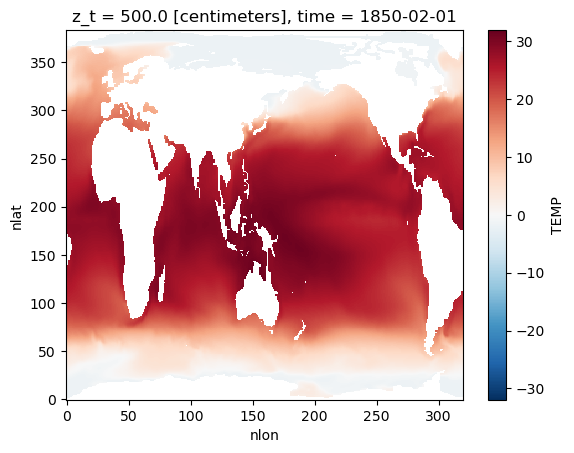

In [23]:
mean_ds.TEMP.isel(time=0, z_t=0).plot()

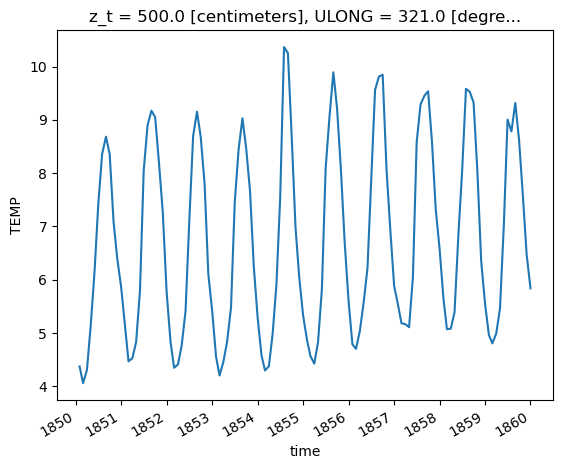

In [24]:
mean_ds.TEMP.isel(z_t=0, nlat=340, nlon=0).plot()

In [25]:
output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
mean_ds.to_netcdf(output_file)

## compute std

In [17]:
ds = xr.open_mfdataset(files, preprocess=standardise_time, concat_dim='new_dim', combine='nested')

In [25]:
ds.var(dim='new_dim')

UFuncTypeError: ufunc 'multiply' cannot use operands with types dtype('<m8[ns]') and dtype('<m8[ns]')

In [ ]:
std_ds.TEMP.isel(z_t=0, nlat=340, nlon=0).plot()

In [ ]:
output_file = os.path.join(output_dir, f'{var}_std_{time_period}.nc')
        std_ds.to_netcdf(output_file)

# check output

In [6]:
output_dir = '/Data/skd/scratch/innag3580/comp/averages/'
file = 'TEMP_mean_185001-185912.nc'

In [7]:
ds = xr.open_dataset(output_dir+file)

In [8]:
ds

<xarray.Dataset>
Dimensions:                 (z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60,
                             z_w_bot: 60, lat_aux_grid: 395, moc_z: 61,
                             nlat: 384, nlon: 320, time: 120)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 ...
    ULAT                    (nlat, nlon) float64 ...
    TLONG                   (nlat, nlon) float64 ...
    TLAT                    (nlat, nlon) float64 ...
  * time                    (time) datetime64[ns] 1850-02-01 ... 1860-01-01
Dimensions without coordinates: nlat, nlon
Data variables: (12/51)
    dz                      (z_t) float32 ...
    dzw                     (z_w) float32 ...
    KMT                     (nlat, nlon) float64 ...
    KMU                     (nlat, nlon) float64 ...
    REGION_MASK             (nlat, nlon) float64 ...
    UAREA                   (nlat, nlon) float64 ...
    ...                      ...
    fwflux_factor           float64 ...
    salinity_factor         float64 ...
    sflux_factor            float64 ...
    nsurface_t              float64 ...
    nsurface_u              float64 ...
    TEMP                    (time, z_t, nlat, nlon) float32 ...

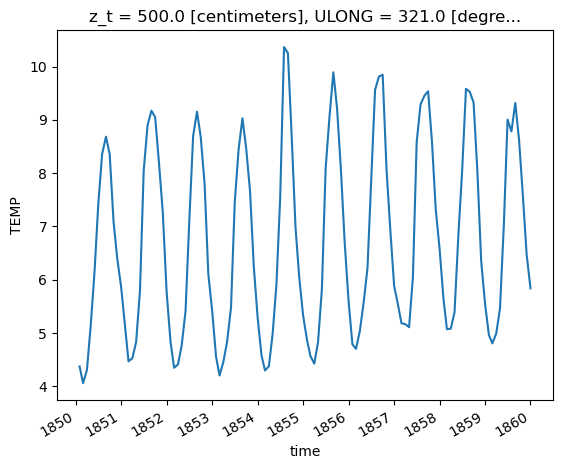

In [9]:
ds.TEMP.isel(z_t=0, nlat=340, nlon=0).plot()

# Compute averages

In [1]:
import xarray as xr
import glob
import os
from dask import delayed, compute

In [2]:
# Directory containing the TEMP files
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP'
#output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/averages'

var = 'TEMP'  # Example variable for testing

# List all TEMP files in the directory (you can limit this to three files for the test)
file_paths = sorted(glob.glob(os.path.join(temp_dir, '*.nc')))

In [3]:
file_paths[0][-16:]

'185001-185912.nc'

In [8]:
# Group files by their time periods
#time_periods = {}
#for file_path in file_paths:
#    # Extract the time period from the filename
#    time_period = file_path.split('.')[-2]
#    if time_period not in time_periods:
#        time_periods[time_period] = []
#    time_periods[time_period].append(file_path)

for file_path in file_paths:
    time_period = file_path.split('.')[-2]
    time_periods.setdefault(time_period, []).append(file_path)

{'185001-185912': ['/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1021.002.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1041.003.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1061.004.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1081.005.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1101.006.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1121.007.pop.h.TEMP.185001-185912.nc',
  '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTcmip6.f09_g17.LE2-1141.008.pop.h

In [ ]:
# Process each group of time periods using Dask
tasks = []
for time_period, files in time_periods.items():
    # Limit to three files for testing
    limited_files = files[:3]

    # Define a delayed task to read and process the dataset
    @delayed
    def process_time_period(files):
        datasets = [xr.open_dataset(file, decode_times=False, chunks='auto') for file in files]
        combined_ds = xr.concat(datasets, dim='member')
        mean_ds = combined_ds.mean(dim='member')
        return mean_ds

    # Add the task for the current time period
    tasks.append(process_time_period(limited_files))

# Compute results in parallel
mean_datasets = compute(*tasks)

# Save results and print filenames
for time_period, mean_ds in zip(time_periods.keys(), mean_datasets):
    #output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
    #output_file = os.path.join(f'{var}_mean_{time_period}.nc')
    mean_ds.to_netcdf(f'{var}_mean_{time_period}.nc')
    print(f'{output_file} saved')

TEMP_mean_185001-185912.nc saved


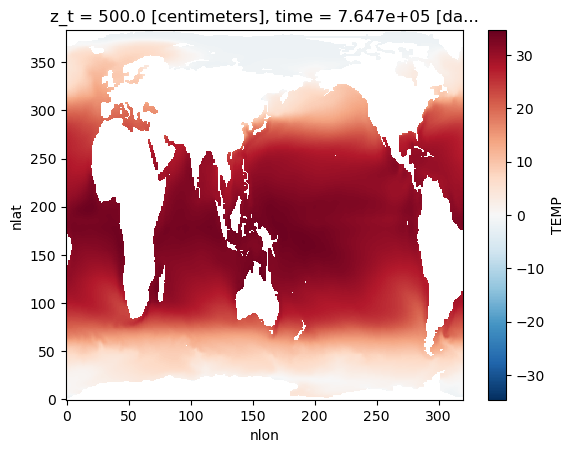

In [10]:
mean_ds.TEMP.isel(time=0, z_t=0).plot()

In [20]:
# Process each group of time periods
for time_period, files in time_periods.items():
    files = files[:3]
    
    # Open all datasets for the current time period
    datasets = [xr.open_dataset(file, decode_times=False) for file in files]
    
    # Concatenate along the 'member' dimension
    combined_ds = xr.concat(datasets, dim='member')
    
    # Compute the mean over the 'member' dimension
    mean_ds = combined_ds.mean(dim='member')
    
    # Save the result to the output directory
    output_file = os.path.join(output_dir, f'TEMP_mean_{time_period}.nc')
    
    print(output_file)
    
    break

/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/averages/TEMP/TEMP_mean_185001-185912.nc


# Not working code

In [ ]:
'''
#!/usr/bin/env python3
# inagler 28/11/24

import xarray as xr
import os
import glob

# Base directory containing the variable folders
base_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly'
output_dir = os.path.join(base_dir, 'averages')

# List of variables
variables = ['TEMP', 'SALT', 'VVEL', 'SHF', 'HMXL', 'TAUX', 'TAUY', 'PSL', 'AICE', 'N_HEAT', 'N_SALT', 'VT']

# Process each variable
for var in variables:
    
    print(f'{var} started')
    
    var_dir = os.path.join(base_dir, var)
    
    # List all files for the current variable
    file_paths = sorted(glob.glob(os.path.join(var_dir, '*.nc')))
    
    # Group files by their time periods
    time_periods = {}
    for file_path in file_paths:
        # Extract the time period from the filename
        time_period = file_path.split('.')[-2]
        if time_period not in time_periods:
            time_periods[time_period] = []
        time_periods[time_period].append(file_path)

    # Process each group of time periods
    for time_period, files in time_periods.items():
        # Open all datasets for the current time period
        datasets = [xr.open_dataset(file, decode_times=False) for file in files]
        
        # Concatenate along the 'member' dimension
        combined_ds = xr.concat(datasets, dim='member')
        
        # Compute the mean over the 'member' dimension
        mean_ds = combined_ds.mean(dim='member')
        
        # Save the result to the output directory
        output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
        mean_ds.to_netcdf(output_file)
        
        print(f'{time_period} saved')
'''

# Improve code

In [1]:
import os
import glob
import xarray as xr
from dask import delayed, compute

# Base directory containing the variable folders
base_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly'
output_dir = '/Data/skd/scratch/innag3580/comp'

In [16]:
variables = ['TEMP', 'SALT', 'VVEL', 'SHF', 'HMXL', 'TAUX', 'TAUY', 'PSL', 'AICE', 'N_HEAT', 'N_SALT', 'VT']
var = variables[11]

In [17]:
var_dir = os.path.join(base_dir, var)
file_paths = sorted(glob.glob(os.path.join(var_dir, '*.nc')))

# Group files by their time periods
time_periods = {}
for file_path in file_paths:
    time_period = file_path.split('.')[-2]
    time_periods.setdefault(time_period, []).append(file_path)

In [ ]:
def process_time_period(time_period, files):
    mean_ds = xr.open_mfdataset(files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')
    output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
    mean_ds.to_netcdf(output_file)
    print(f'mean for {time_period} saved')
    return mean_ds

In [ ]:
xr.open_mfdataset(files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')

In [ ]:
tasks = [delayed(process_time_period)(time_period, files) for time_period, files in time_periods.items()]
dask.compute(*tasks)


In [ ]:


# Process each variable
for var in variables:
    print(f'Start processing variable: {var}')

    var_dir = os.path.join(base_dir, var)
    file_paths = sorted(glob.glob(os.path.join(var_dir, '*.nc')))
    
    # Group files by their time periods
    time_periods = {}
    for file_path in file_paths:
        time_period = file_path.split('.')[-2]
        time_periods.setdefault(time_period, []).append(file_path)

    # Process each group of time periods using Dask
    tasks = []
    for time_period, files in time_periods.items():
        print(f'Processing time period: {time_period}')

        # Define a delayed task to read and process the dataset
        @delayed
        
        # defining functions in a loop is useful for creating unique functions for 
        # each iteration, ensuring that they capture the correct data and can operate
        # appropriately when executed late

        # Add the task for the current time period
        tasks.append(process_time_period(files))
# test code
    # Compute results in parallel
    print(f'Starting computation for {var}...')
    mean_datasets = compute(*tasks)
    print(f'Computation completed for {var}.')

    # Save results and print filenames
    for time_period, mean_ds in zip(time_periods.keys(), mean_datasets):
        output_file = os.path.join(output_dir, f'{var}_mean_{time_period}.nc')
        mean_ds.to_netcdf(output_file)
        print(f'Saved: {output_file}')

# test if variables are deprecated

In [4]:
import xarray as xr
import glob
import os

In [8]:
var = 'VVEL'

base_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly'
var_dir = os.path.join(base_dir, var)
file_paths = sorted(glob.glob(os.path.join(var_dir, '*.nc')))

for file_path in file_paths:
    try:
        ds = xr.open_dataset(file_path)
        #if var in ds.variables:
        #    print(f"Variable '{var}' found in file: {file_path}")
        #else:
        #    print(f"Variable '{var}' NOT found in file: {file_path}")
    except Exception as e:
        print(f"Error opening file {file_path}: {e}")


Error opening file /Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.pop.h.VVEL.197001-197912.nc: [Errno -101] NetCDF: HDF error: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTcmip6.f09_g17.LE2-1231.002.pop.h.VVEL.197001-197912.nc'


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140315727288128:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1652 in H5F_open(): unable to read superblock
    major: File accessibilty
    minor: Read failed
  #002: H5Fsuper.c line 632 in H5F__super_read(): truncated file: eof = 481722141, sblock->base_addr = 0, stored_eof = 1861778084
    major: File accessibilty
    minor: File has been truncated


Error opening file /Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTsmbb.f09_g17.LE2-1281.012.pop.h.VVEL.193001-193912.nc: [Errno -101] NetCDF: HDF error: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTsmbb.f09_g17.LE2-1281.012.pop.h.VVEL.193001-193912.nc'


HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140315727288128:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1652 in H5F_open(): unable to read superblock
    major: File accessibilty
    minor: Read failed
  #002: H5Fsuper.c line 632 in H5F__super_read(): truncated file: eof = 530524664, sblock->base_addr = 0, stored_eof = 1861541424
    major: File accessibilty
    minor: File has been truncated
